# Noise

雜訊（英語：Noise）在電子學中指，訊號在傳輸過程中會受到一些外在能量所產生訊號（如雜散電磁場）的干擾，這些能量即雜訊。雜訊通常會造成訊號的失真。其來源除了來自系統外部，亦有可能由接收系統本身產生。

在資訊理論裡，不是我們所想要的資訊就叫做Noise，雜訊會干擾信息的傳遞，因此我們會試圖去噪，透過修復或捨棄等等方式降低Noise對資訊的影響力。

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt



class Noiser():
    def __init__(self, random_state = 42):
        self.rng = np.random.RandomState(random_state)
    def salt_pepper_noise(self, img, n):
        img = img.copy()
        rows = self.rng.randint(0, img.shape[0], size=n)
        cols = self.rng.randint(0, img.shape[1], size=n)
        for i, j in zip(rows, cols):
            img[i][j] = self.rng.randint(0, 2)*255
        return img
    def guass_noise(self, img, mean, std):
        img = img.copy()
        noise = np.random.normal(mean, std, size = img.shape)
        img = img+noise
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                img[i][j] = round(min(max(0, img[i][j]), 255))
        return img



# Salt Pepper Noise

椒鹽噪聲也稱為脈衝雜訊，是圖像中經常見到的一種雜訊，它是一種隨機出現的白點或者黑點。椒鹽噪聲的成因可能是影像訊號受到突如其來的強烈干擾而產生、模數轉換器或位元傳輸錯誤等。例如失效的感應器導致像素值為最小值，飽和的感應器導致像素值為最大值。

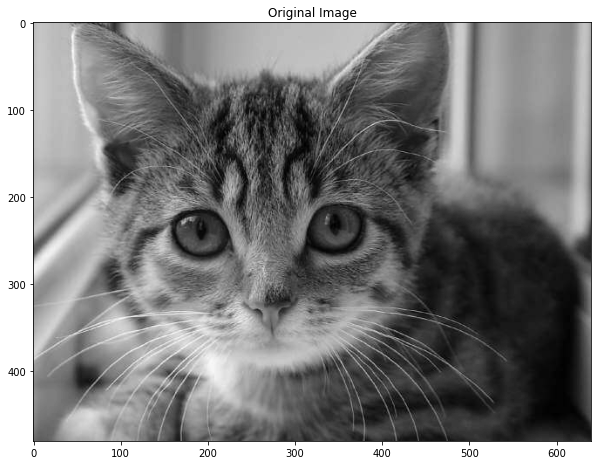

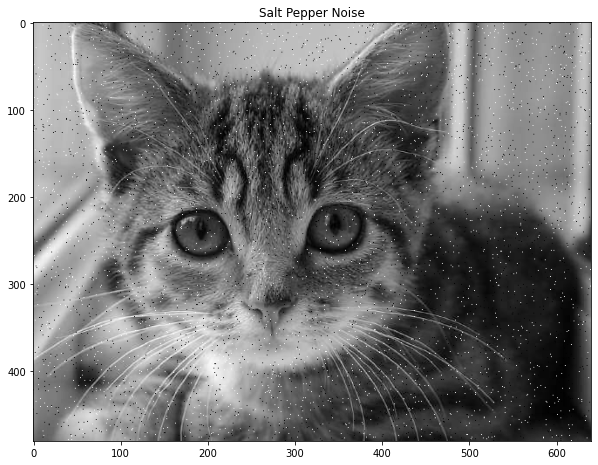

In [2]:
img = cv2.imread('kitty.jpg', 0) # 0: gray, 1:color, -1 color with alpha
plt.figure(figsize=(10, 10))
plt.imshow(img, 'gray')
plt.title('Original Image')
plt.show()

# ADD NOISE
noiser = Noiser()
im = noiser.salt_pepper_noise(img, 5000)
plt.figure(figsize=(10, 10))
plt.imshow(im, 'gray')
plt.title('Salt Pepper Noise')
plt.show()

# Gauss Noise

高斯噪聲是指它的概率密度函數服從高斯分佈（即正態分佈）的一類噪聲

與椒鹽噪聲相似（Salt And Pepper Noise），高斯噪聲（gauss noise）也是數字圖像的一個常見噪聲。

椒鹽噪聲是出現在隨機位置、噪點深度基本固定的噪聲，高斯噪聲與其相反，是幾乎每個點上都出現噪聲、噪點深度隨機的噪聲。

高斯噪聲出現的原因很大一部分是人為，為什麼說是人為呢? 因為在真實情況中，訊息的傳遞會產生雜訊(Noise)，而我們無法預測Noise會產生在哪裡，所以我們會通過高斯常態分布幫資訊增加Noise，作為我們後續測試我們去噪演算法的測試資料。

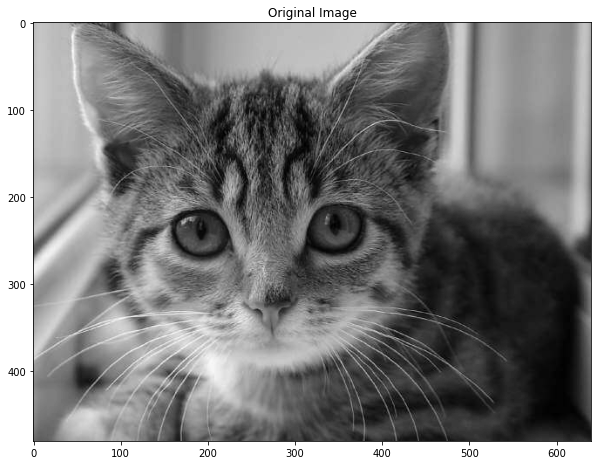

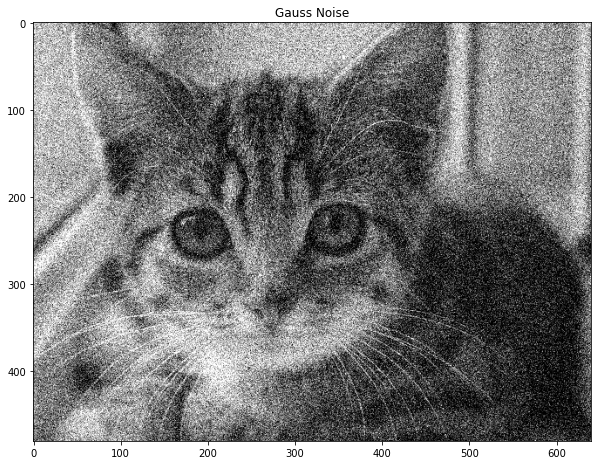

In [3]:
img = cv2.imread('kitty.jpg', 0) # 0: gray, 1:color, -1 color with alpha
plt.figure(figsize=(10, 10))
plt.imshow(img, 'gray')
plt.title('Original Image')
plt.show()

# ADD NOISE
noiser = Noiser()
im = noiser.guass_noise(img, 0, 50)  # mean=0, std=50
plt.figure(figsize=(10, 10))
plt.imshow(im, 'gray')
plt.title('Gauss Noise')
plt.show()

# Filter 濾波器

濾波器的目的是在抑制電磁雜訊，雜訊的影響，在影像處理中，我們多半將對每一個像素進行處理的funtion稱之為濾波器，廣義的濾波器定義也變成對資料的特徵擷取。

以下會實作一些簡單的Filter，透過卷積(Convolution)的方式復現各種濾波器

# 何謂卷積(Convoluation)

從數學上講，卷積就是一種運算。某種運算，能被定義出來，至少有以下特徵：

* 首先是抽象的、符號化的
* 在生活、科研中，有著廣泛的作用

比如加法，a+b是抽象的，本身只是一個數學符號，在現實中，有非常多的意義，比如增加、合成、旋轉等等
卷積，是我們學習高等數學之後，新接觸的一種運算，因為涉及到積分、級數，所以看起來覺得很複雜。

## 卷積的定義


我們稱為 $ (f*g)(n) $ 為f, g的捲積

$$ (f*g)(n) = \int_{-\infty}^{\infty} f(t)g(n-t)dt$$

## 線性代數定義:

https://medium.com/@chih.sheng.huang821/%E5%8D%B7%E7%A9%8D%E7%A5%9E%E7%B6%93%E7%B6%B2%E8%B7%AF-convolutional-neural-network-cnn-%E5%8D%B7%E7%A9%8D%E9%81%8B%E7%AE%97-%E6%B1%A0%E5%8C%96%E9%81%8B%E7%AE%97-856330c2b703

### 資料: 
https://www.zhihu.com/question/22298352

In [4]:
import numpy as np
import math


def do_padding(mat, padding):
    y, x = mat.shape
    m = np.zeros(shape=(y+padding*2, x+padding*2))
    m[padding:y+padding, padding:x+padding] = mat
    return m


def cal_padding(mat_size, kernel_size, stride):
    padding = (mat_size-1)*stride+kernel_size-mat_size
    padding = math.ceil(padding/2)
    return padding


class Conv():
    def __init__(self, kernel, padding=-1, stride=1):
        self.kernel = kernel
        self.padding = padding
        self.stride = stride
    def __call__(self, mat):
        padding = self.padding
        # padding補正
        if self.padding == -1:
            padding = cal_padding(mat.shape[0], self.kernel.shape[0], self.stride)
            
        return self._forward(do_padding(mat, padding), self.stride)


    def _forward(self, mat, stride):
        raise NotImplementedError('')



### Padding & Stride

在影像處理中我們應用了數學中的卷積運算，但實際中我們除了kernel以外還會設定padding 與stride。

什麼是padding呢? 
* 實際上就是補邊長大小，因為做完卷積後的影像必定<=原圖大小，所以我們會在周圍捕0放大原圖，確保運算後的圖片大小與原圖一致

什麼是stride呢?
* 移動步長，通常我們移動都是間隔1，但是我們也可以設定間隔大小，當然間隔越大運算後的圖形越小

所以我們可以得到卷積後算
### 新的feature map長寬的公式如下:

$$ W_{after} = floor(\frac{W_{origin} + 2*padding-kernel\_size}{stride})+1 $$

### Same Size:

$$ Padding = Ceil(\frac{(W_{origin}-1)*stride+kernel\_size - W_{origin}}{2})$$



In [5]:
mat = np.ones(shape=(5, 5))
do_padding(mat, padding=2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

# Mean Filter(均值濾波器)


所謂的均值，也就是平均值的意思，意思就是先找一個點為中心，把3*3的範圍加總起來做平均寫入覆蓋原本的值。



In [6]:
class AvgFilter(Conv):
    def __init__(self, kernel=3, padding=-1, stride=1):
        super().__init__(np.ones(shape=(kernel, kernel)), padding, stride)
    def _forward(self, mat, stride):
        m = []
        y, x = mat.shape
        yk, xk = self.kernel.shape
        for i in range(0, y, stride):
            if i + yk > y:
                break
            arr = []
            for j in range(0, x, stride):
                if j + xk > x:
                    break

                t = mat[i:i + yk, j:j + xk] * self.kernel
                arr.append(t.mean()) #插入平均值
            m.append(arr)
        return np.array(m)



In [7]:
mat = np.ones(shape=(5, 5))
avg_filter = AvgFilter()
avg_filter(mat)

array([[0.44444444, 0.66666667, 0.66666667, 0.66666667, 0.44444444],
       [0.66666667, 1.        , 1.        , 1.        , 0.66666667],
       [0.66666667, 1.        , 1.        , 1.        , 0.66666667],
       [0.66666667, 1.        , 1.        , 1.        , 0.66666667],
       [0.44444444, 0.66666667, 0.66666667, 0.66666667, 0.44444444]])

# Median Filter(中位數濾波器)

中值濾波器（Median filtering） 如其名所隱含的，它將一個像素的值用該像素鄰域中強度值的中間值來取代（計算中間值的過程中，也會將該像素的原始值包含），中值濾波器在處理椒鹽噪聲上能提供絕佳的雜訊降低效能。中值濾波器所衍伸的問題是計算速率

In [8]:
class MedianFilter(Conv):
    def __init__(self, kernel=3, padding=-1, stride=1):
        super().__init__(np.ones(shape=(kernel, kernel)), padding, stride)
    def _forward(self, mat, stride):
        m = []
        y, x = mat.shape
        yk, xk = self.kernel.shape
        for i in range(0, y, stride):
            if i + yk > y:
                break
            arr = []
            for j in range(0, x, stride):
                if j + xk > x:
                    break

                t = mat[i:i + yk, j:j + xk] * self.kernel
                arr.append(np.median(t.reshape(-1)))  # 插入中位數
            m.append(arr)
        return np.array(m)

In [9]:
median_filter = MedianFilter()
mat = np.ones(shape=(7, 7))
print(median_filter(mat))

[[0. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 0.]]


# 量化函數SNR

訊號雜訊比（英語：Signal-to-noise ratio，縮寫為SNR或S/N），又稱訊噪比，是科學和工程中所用的一種度量，用於比較所需訊號的強度與背景雜訊的強度

### 公式:

$$ SNR = 10 * log_{10}\left(Mean\left( \frac{Signal^2}{Noise^2} \right)\right)$$

In [10]:
def snr(origin, noise):
    origin = origin.reshape(-1)
    noise = noise.reshape(-1)+1e-7
    snr = ((origin/noise)**2).mean()
    return 10*math.log10(snr)

Orininal SNR:  181.81672962725034


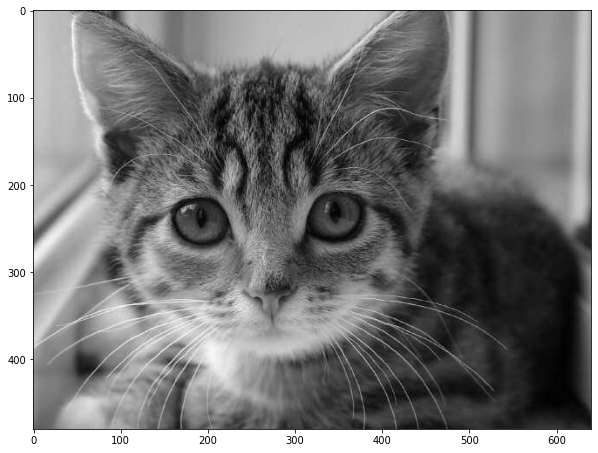

In [11]:
img = cv2.imread('kitty.jpg', 0)
print('Orininal SNR: ', snr(img, np.zeros_like(img)))
plt.figure(figsize=(10, 10))
plt.imshow(img, 'gray')
plt.show()

Guass SNR:  163.25878195073784


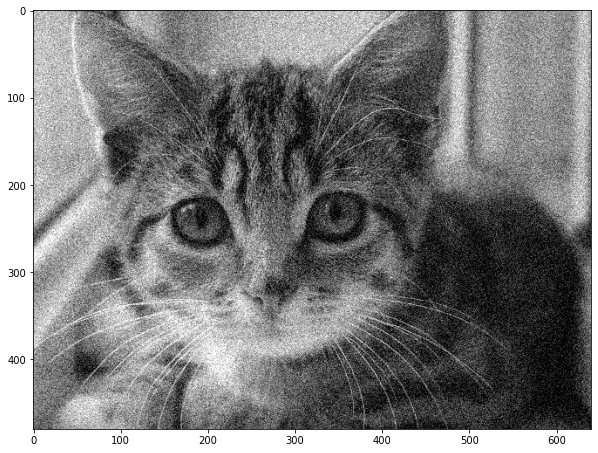

In [12]:
noiser = Noiser()
guass_img = noiser.guass_noise(img, 0, 30)
print('Guass SNR: ', snr(img, guass_img-img))
plt.figure(figsize=(10, 10))
plt.imshow(guass_img, 'gray')
plt.show()


SaltPepper SNR:  181.74596532729947


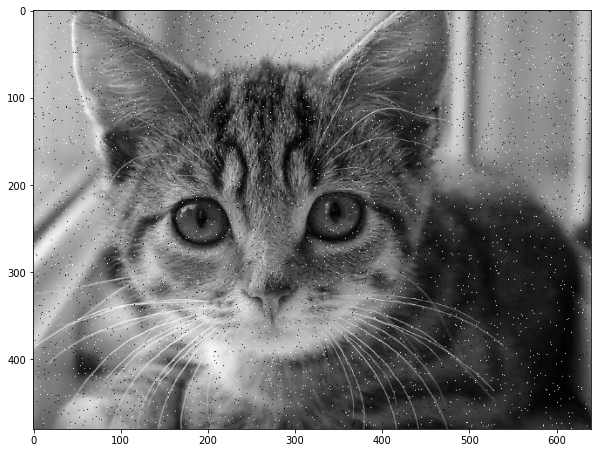

In [13]:
salt_img = noiser.salt_pepper_noise(img, 5000)
print('SaltPepper SNR: ', snr(img, salt_img-img))
plt.figure(figsize=(10, 10))
plt.imshow(salt_img, 'gray')
plt.show()


# Filter對Noise的影響

Mean Filter SNR:  171.58551554508776


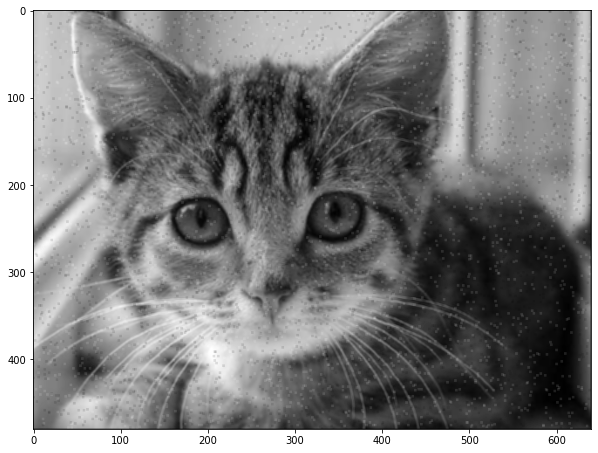

Median Filter SNR:  179.49326780210637


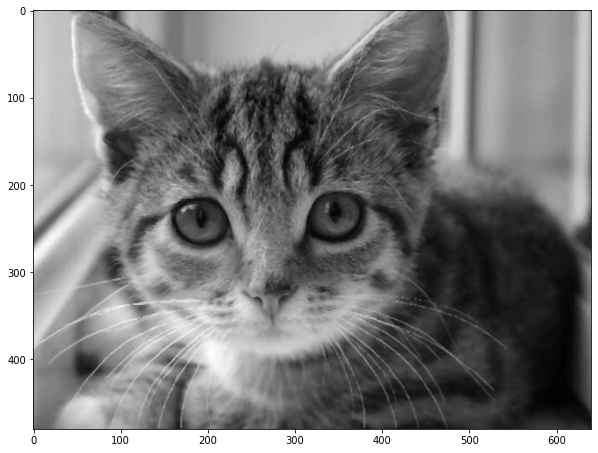

In [14]:
# salt and pepper

fixed = avg_filter(salt_img)
print('Mean Filter SNR: ', snr(img, fixed-img))
plt.figure(figsize=(10, 10))
plt.imshow(fixed, 'gray')
plt.show()


fixed = median_filter(salt_img)
print('Median Filter SNR: ', snr(img, fixed-img))
plt.figure(figsize=(10, 10))
plt.imshow(fixed, 'gray')
plt.show()

Mean Filter SNR:  157.57094866507055


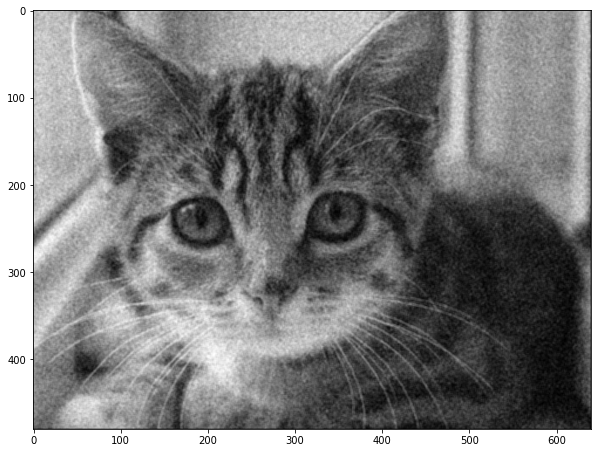

Median Filter SNR:  166.66364403409642


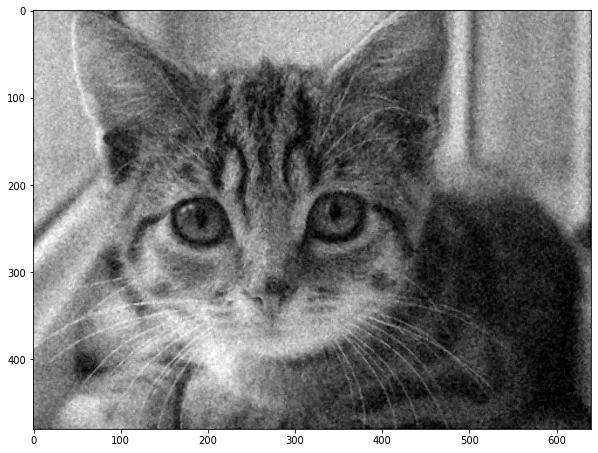

In [15]:
# Guass Noise

fixed = avg_filter(guass_img)
print('Mean Filter SNR: ', snr(img, fixed-img))
plt.figure(figsize=(10, 10))
plt.imshow(fixed, 'gray')
plt.show()


fixed = median_filter(guass_img)
print('Median Filter SNR: ', snr(img, fixed-img))
plt.figure(figsize=(10, 10))
plt.imshow(fixed, 'gray')
plt.show()

Guass * 100 Fixed SNR:  172.909698090569


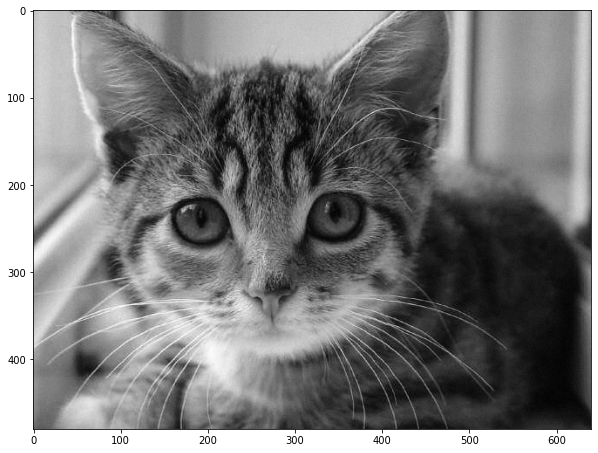

In [16]:
# 百圖相加


fixed = np.zeros_like(img).astype('float64')

for i in range(100):
    fixed += noiser.guass_noise(img, 0, 30).astype('float64')
fixed = fixed/100
fixed = fixed.astype('uint8')

print('Guass * 100 Fixed SNR: ', snr(img, fixed-img))
plt.figure(figsize=(10, 10))
plt.imshow(fixed, 'gray')
plt.show()